# COGS 108 - EDA Checkpoint

# Names

- Wilson Tan
- Cameron VanderTuig
- Henry Chan
- Erdogan Ergit
- Tony Diep

<a id='research_question'></a>
# Research Question

How does the release of popular and graphically intensive games affect GPU sales globally?

# Setup

In [6]:
import requests
import patsy
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from bs4 import BeautifulSoup

Web Scraping: GPUs

Using the code below, we scraped for GPU data per month in a span of 2017-2019 from Steam and generated CSV files per month within the time span. This time span was chosen because months in 2016 didn't contain DirectX 12 GPUs and there existed a chip shortage for years after 2019 (2020, 2021). NOTE: The code below will take a bit of time (5-10 minutes).

The data we get from this is the name and change in percentage of usage per month. The name will be used later to determine if a game was graphically demanding for the time it was released in. Since we were unable to find hard sales number of GPUs, we will use the change of usage of GPUs as an estimation to sales number.

In [2]:
URL_list = ["https://web.archive.org/web/20170204151909/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20170320025938/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20170422161750/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20170503175753/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20170618032247/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20170705015411/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20170809050802/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20170920194147/http://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20171003234409/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20171129124710/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20171225035718/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20180105060833/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20180210024431/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20180310085647/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20180425133033/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20180507133018/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20180610133020/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20180710005013/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20180802141837/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20180903133021/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20181009051159/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20181105143022/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20181211111854/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20190105143027/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20190215143015/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20190305143013/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20190405045048/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20190519120607/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20190602014350/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20190707174637/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20190804152253/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20190916114159/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20191020210658/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20191102133406/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20191209230550/https://store.steampowered.com/hwsurvey/videocard/",
"https://web.archive.org/web/20200103034839/https://store.steampowered.com/hwsurvey/videocard/"
]

dates = {1: "Jan",
2: "Feb",
3: "Mar",
4: "Apr",
5: "May",
6: "Jun",
7: "Jul",
8: "Aug",
9: "Sep",
10: "Oct",
11: "Nov",
12: "Dec"
}

count = 1
year = 2017

# Get URL
for x in URL_list:
	URL = x
	page = requests.get(URL)
	print(f"{dates.get(count)} {year}")

	soup = BeautifulSoup(page.content, "html.parser")

	# Get names and increase/decrease percentages
	name = soup.find_all("div", {"class", "substats_col_left"})
	stat = soup.find_all("span", {"class", "stat_increase", "stat_decrease", "stat_unchanged"})

	names = []
	stats = []
	performances = []
	directx_version = []

	for tag in stat:
		stats.append(tag.text.strip())

	for x in range(1, 7):
		stats.pop(0)

	temp = ""
	unwanted = ["overall distribution of cards", "directx 11 gpus", "directx 10 gpus", "directx 9 shader model 2b and 3.0 gpus",
	"directx 9 shader model 2.0 gpus", "directx 8 gpus and below", "all video cards"]

	# "directx 12 gpus"

	directx = 0

	# Append only the wanted names
	for tag in name:
		temp = tag.text.strip()
		if (temp.lower() in unwanted):
			directx = 0
			continue

		# Limit to 3 most recent DirectX versions 
		if (temp.lower() == "directx 12 gpus"):
			directx = 12
			continue

		directx_version.append(directx)
		names.append(temp)

	df = pd.DataFrame({"GPU Name": names, "Change (%)": stats, "DirectX Version": directx_version})
	df = df[df["DirectX Version"] != 0]
	df.set_index(np.array(range(0, df.shape[0])), inplace=True)
	df.to_csv(f"{dates.get(count)}_{year}_GPUs", encoding="utf-8", index=False)

	count+=1
	if (count == 13):
		count = 1
		year += 1

	page.close()

From the code above, we get multiple CSV files. These files are contained in the list "files". Since every month will have duplicate GPU names, we can create a set, "GPUs", to get unique GPUs only.

In [3]:
GPUs = set([])
files = ["Jan_2017_GPUs", "Feb_2017_GPUs", "Mar_2017_GPUs", "Apr_2017_GPUs", "May_2017_GPUs", "Jun_2017_GPUs", 
        "Jul_2017_GPUs", "Aug_2017_GPUs", "Sep_2017_GPUs", "Oct_2017_GPUs", "Nov_2017_GPUs", "Dec_2017_GPUs",
        "Jan_2018_GPUs", "Feb_2018_GPUs", "Mar_2018_GPUs", "Apr_2018_GPUs", "May_2018_GPUs", "Jun_2018_GPUs", 
        "Jul_2018_GPUs", "Aug_2018_GPUs", "Sep_2018_GPUs", "Oct_2018_GPUs", "Nov_2018_GPUs", "Dec_2018_GPUs",
        "Jan_2019_GPUs", "Feb_2019_GPUs", "Mar_2019_GPUs", "Apr_2019_GPUs", "May_2019_GPUs", "Jun_2019_GPUs", 
        "Jul_2019_GPUs", "Aug_2019_GPUs", "Sep_2019_GPUs", "Oct_2019_GPUs", "Nov_2019_GPUs", "Dec_2019_GPUs"]

In [4]:
for x in files:
    df = pd.read_csv(x)
    df = df[df["GPU Name"] != "Other"]
    df["GPU Name"].apply(lambda x: GPUs.add(x))
    
GPUs

{'AMD Radeon HD 7480D',
 'AMD Radeon HD 7540D',
 'AMD Radeon HD 7700 Series',
 'AMD Radeon HD 7800 Series',
 'AMD Radeon HD 7900 Series',
 'AMD Radeon HD 8370D',
 'AMD Radeon HD 8470D',
 'AMD Radeon HD 8500 Series',
 'AMD Radeon HD 8600 Series',
 'AMD Radeon HD 8800 Series',
 'AMD Radeon R4 Graphics',
 'AMD Radeon R5 Graphics',
 'AMD Radeon R5 M330',
 'AMD Radeon R7 200 Series',
 'AMD Radeon R7 300 Series',
 'AMD Radeon R7 Graphics',
 'AMD Radeon R9 200 Series',
 'AMD Radeon R9 380 Series',
 'AMD Radeon R9 390 Series',
 'AMD Radeon RX 460',
 'AMD Radeon RX 470',
 'AMD Radeon RX 480',
 'AMD Radeon RX 550',
 'AMD Radeon RX 560',
 'AMD Radeon RX 570',
 'AMD Radeon RX 580',
 'AMD Radeon RX Vega',
 'AMD Radeon Vega 8 Graphics',
 'Intel HD Graphics 4400',
 'Intel HD Graphics 4600',
 'Intel HD Graphics 5000',
 'Intel HD Graphics 520',
 'Intel HD Graphics 530',
 'Intel HD Graphics 5500',
 'Intel HD Graphics 6000',
 'Intel HD Graphics 620',
 'Intel HD Graphics 630',
 'Intel Iris Graphics 5100',

In [5]:
GPUs = list(GPUs)

Web Scraping: Performance

Data from Steam only provided us with the name and change in usage percentage. However, in order to determine the performance of a GPU, we would need to scrape a different site, "benchmarks.ul.com".

Performance will tell us whether a game is demanding for when it was released, and how new/old a GPU is. Newer GPUs have higher performances, so when given a list of GPUs and their performances, we're able to determine which GPU are newest.

In [6]:
performances = []
for name in GPUs:

	card = name.replace(" ", "+")

	URL = "https://benchmarks.ul.com/hardware/gpu/" + card + "+review"
	page = requests.get(URL)

	soup = BeautifulSoup(page.content, "html.parser")

	try:
		performance = soup.find_all("span", {"class", "result-pimp-badge-score-item"})[0].text.strip()
		performances.append(performance)
	except:
		performances.append(0)

	page.close()

With the list of GPUs and performances, we can create a dictionary to easily grab the performance of the GPU

In [7]:
GPU_dict = dict(zip(GPUs, performances))
GPU_dict

{'AMD Radeon HD 8500 Series': 0,
 'NVIDIA GeForce GTX 970M': '2282',
 'NVIDIA GeForce GTX 770': '2158',
 'Intel HD Graphics 520': 0,
 'AMD Radeon RX 580': '4294',
 'AMD Radeon R5 M330': 0,
 'NVIDIA GeForce GTX 680': '2019',
 'Intel HD Graphics 6000': 0,
 'NVIDIA GeForce GT 720M': 0,
 'AMD Radeon HD 8600 Series': 0,
 'AMD Radeon HD 7800 Series': 0,
 'NVIDIA GeForce GTX 980 Ti': '5802',
 'AMD Radeon RX 480': '4087',
 'NVIDIA GeForce GT 710': '200',
 'NVIDIA GeForce 920MX': '384',
 'NVIDIA GeForce GTX 860M': '1156',
 'AMD Radeon R9 390 Series': 0,
 'NVIDIA GeForce GT 440': 0,
 'NVIDIA GeForce GT 630M': 0,
 'NVIDIA GeForce GTX 1660': '5469',
 'NVIDIA GeForce GTX 780': '2844',
 'Intel Iris Graphics 5100': 0,
 'Intel HD Graphics 5500': '234',
 'NVIDIA GeForce GTX 745': '656',
 'NVIDIA GeForce GTX 1050': '1738',
 'NVIDIA GeForce GTX 650 Ti': '906',
 'AMD Radeon R9 200 Series': 0,
 'NVIDIA GeForce 920M': '326',
 'NVIDIA GeForce GTX 760': '1690',
 'NVIDIA GeForce RTX 2070': '9125',
 'NVIDIA GeF

Now that we have GPU names, percentage change per month, and performances, we have complete web scraping for GPUs.

Games

With GPU names and their performances, we're able to determine whether the GPU is new/old and whether a game is demanding or not. However, we would also need a list of games within our time frame to measure whether release of popular, demanding games affect the sales number of GPUs.

Because we're using Steam data, we will only be taking a look at games on Steam.

By using the Steam reviews of the games, we can determine the popularity of the game. URLs and names will be used to simply indicate what game we're looking at and date will be their release date

In [8]:
# Create dataframe (Game name)
df_game_main = pd.read_csv('Game_Main.csv')
df_game_main

,url,name,all_reviews,date
0,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,"Very Positive(4,843,904)- 87% of the 4,843,904...",21-Aug-12
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,"Very Positive(223,706)- 80% of the 223,706 use...",3-Aug-20
3,https://store.steampowered.com/app/1158310/Cru...,Crusader Kings III,"Very Positive(18,951)- 92% of the 18,951 user ...",1-Sep-20
4,https://store.steampowered.com/app/1085660/Des...,Destiny 2,"Very Positive(284,689)- 86% of the 284,689 use...",1-Oct-19
...,...,...,...,...
81043,https://store.steampowered.com/bundle/2961/Ste...,-,-,-
81044,https://store.steampowered.com/bundle/3123/Det...,-,-,-
81045,https://store.steampowered.com/bundle/3175/Fea...,-,-,-
81046,https://store.steampowered.com/bundle/3176/Fea...,-,-,-


Requirements of a game will be needed to determine how demanding a game is.

In [9]:
# Create dataframe (Game name)
df_game_requirements = pd.read_csv('Game_Requirements.csv')
df_game_requirements

,url,requirements
0,https://store.steampowered.com/app/945360/Amon...,System RequirementsMinimum:OS: Windows 7 SP1+P...
1,https://store.steampowered.com/app/730/Counter...,System RequirementsWindowsMac OS XSteamOS + Li...
2,https://store.steampowered.com/app/1097150/Fal...,System RequirementsMinimum:Requires a 64-bit p...
3,https://store.steampowered.com/app/1158310/Cru...,System RequirementsWindowsMac OS XSteamOS + Li...
4,https://store.steampowered.com/app/1085660/Des...,System RequirementsMinimum:Requires a 64-bit p...
...,...,...
81043,https://store.steampowered.com/bundle/2961/Ste...,-
81044,https://store.steampowered.com/bundle/3123/Det...,-
81045,https://store.steampowered.com/bundle/3175/Fea...,-
81046,https://store.steampowered.com/bundle/3176/Fea...,-


# Data Cleaning

Data Cleaning: GPUs

Although we scraped for the GPU data, we still have a few issues to clean up.

Remove Other and DirectX Version:
Data from Steam included an "Other" GPU label. This is unusable and needs to be dropped. During setup, we used the DirectX Version to pick out only DirectX Version 12 GPUs, but is no longer needed.

Get Performance list:
Earlier in our setup, we created a dictionary which used the GPU names as keys and performance as values. We use that here to grab the performance values for the GPUs in a month.

Replace 0 values:
When scraping for performances, some values came back as 0 which indicated that it didn't have a performance score. We can fill in these 0 values by using the mean performance of the GPUs for that month.
NOTE: The mean performance score was intentionally left as an integer. Performance data scraped are either originally integers, or were converted to integers. Also, the performance score will be used to determine the higher performing GPUs that month and keeping it as an integer will have no effect.

Get GPUs above 75th percentile:
To determine which GPUs are high performing, we are taking everything above the 75th percentile.

In [10]:
for x in files:
    
    # Remove Other and DirectX Version
    performances = []
    df = pd.read_csv(x)
    df = df[df["GPU Name"] != "Other"]
    df.drop(labels="DirectX Version", axis=1, inplace=True)

    # Get performance list
    performances = list(df["GPU Name"].apply(lambda x: GPU_dict.get(x)))
    
    df["Performance (3DMark)"] = performances
    df["Performance (3DMark)"] = df["Performance (3DMark)"].apply(lambda x: int(x))
    
    # Replace 0 values. Took mean as an integer because Performance scores were also converted to ints
    mean = int(df["Performance (3DMark)"].mean())
    df["Performance (3DMark)"] = df["Performance (3DMark)"].replace(0, mean)
    
    # Get GPUs above 75th percentile
    percentile = df["Performance (3DMark)"].quantile([0.75]).loc[0.75]
    df = df.loc[df["Performance (3DMark)"] > percentile]
    df = df.set_index(np.array(range(0, df.shape[0])))
    
    df.to_csv(f"{x}_75", encoding="utf-8", index=False)

Data Cleaning: Games

We can combine df1 and df2

In [11]:
df_game = pd.merge(df_game_main, df_game_requirements)

We then drop any empty row ( == '-')

In [12]:
df_game.drop(df_game.loc[df_game['url'] == "-"].index, inplace=True)
df_game.drop(df_game.loc[df_game['name'] == "-"].index, inplace=True)
df_game.drop(df_game.loc[df_game['all_reviews'] == "-"].index, inplace=True)
df_game.drop(df_game.loc[df_game['date'] == "-"].index, inplace=True)
df_game.drop(df_game.loc[df_game['requirements'] == "-"].index, inplace=True)

df_game

,url,name,all_reviews,date,requirements
0,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
1,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
2,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
3,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
4,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
...,...,...,...,...,...
81379,https://store.steampowered.com/app/1346541/STA...,STAR WARS™: The Old Republic™ - Sith Bundles,"21 Jul, 2020","21 Jul, 2020",System RequirementsMinimum:OS: Windows 7 or la...
81380,https://store.steampowered.com/app/1347970/Pat...,Patch Quest,Late 2020,Late 2020,System RequirementsMinimum:OS: Windows 10Proce...
81381,https://store.steampowered.com/app/1349120/_/?...,球球少女,"6 Nov, 2020","6 Nov, 2020",System RequirementsMinimum:OS: WIN7 SP1/WIN8/W...
81382,https://store.steampowered.com/app/1349170/Fur...,Furries & Scalies & Bears OH MY! 2: Return to ...,"20 Apr, 2021","20 Apr, 2021",System RequirementsWindowsSteamOS + LinuxMinim...


Remove duplicates

In [13]:
df_game.drop_duplicates(inplace=True, keep="first")
df_game = df_game.dropna()
df_game.set_index(np.array(range(0, df_game.shape[0])), inplace=True)
df_game

,url,name,all_reviews,date,requirements
0,https://store.steampowered.com/app/945360/Amon...,Among Us,"Overwhelmingly Positive(224,878)- 95% of the 2...",16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,"Very Positive(4,843,904)- 87% of the 4,843,904...",21-Aug-12,System RequirementsWindowsMac OS XSteamOS + Li...
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,"Very Positive(223,706)- 80% of the 223,706 use...",3-Aug-20,System RequirementsMinimum:Requires a 64-bit p...
3,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,"Very Positive(223,725)- 80% of the 223,725 use...",3-Aug-20,System RequirementsMinimum:Requires a 64-bit p...
4,https://store.steampowered.com/app/1158310/Cru...,Crusader Kings III,"Very Positive(18,951)- 92% of the 18,951 user ...",1-Sep-20,System RequirementsWindowsMac OS XSteamOS + Li...
...,...,...,...,...,...
74220,https://store.steampowered.com/app/1346541/STA...,STAR WARS™: The Old Republic™ - Sith Bundles,"21 Jul, 2020","21 Jul, 2020",System RequirementsMinimum:OS: Windows 7 or la...
74221,https://store.steampowered.com/app/1347970/Pat...,Patch Quest,Late 2020,Late 2020,System RequirementsMinimum:OS: Windows 10Proce...
74222,https://store.steampowered.com/app/1349120/_/?...,球球少女,"6 Nov, 2020","6 Nov, 2020",System RequirementsMinimum:OS: WIN7 SP1/WIN8/W...
74223,https://store.steampowered.com/app/1349170/Fur...,Furries & Scalies & Bears OH MY! 2: Return to ...,"20 Apr, 2021","20 Apr, 2021",System RequirementsWindowsSteamOS + LinuxMinim...


We're only interested in number of reviews and percentage of likes. We can use regular expressions and the apply function to get rid of useless information.

In [14]:
df_game["all_reviews"] = df_game["all_reviews"].apply(lambda x: x.lower())
df_game["all_reviews"] = df_game["all_reviews"].apply(lambda x: x.strip())
df_game["all_reviews"] = df_game["all_reviews"].apply(lambda x: re.sub("[^0-9\s]", "", x))
df_game["all_reviews"]

<ipython-input-14-b509d8a4284a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game["all_reviews"] = df_game["all_reviews"].apply(lambda x: x.lower())
<ipython-input-14-b509d8a4284a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game["all_reviews"] = df_game["all_reviews"].apply(lambda x: x.strip())
<ipython-input-14-b509d8a4284a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

0           224878 95   224878       
1         4843904 87   4843904       
2           223706 80   223706       
3           223725 80   223725       
4             18951 92   18951       
                     ...             
74220                        21  2020
74221                            2020
74222                         6  2020
74223                        20  2021
74224                        12  2017
Name: all_reviews, Length: 74225, dtype: object

Notice how the bottom 5 reviews are different from the top 5. Some reviews are unusable to us, so we can get rid of those rows.

In [15]:
df_game = df_game[df_game["all_reviews"].str.split().apply(len) == 3]
df_game.set_index(np.array(range(0, df_game.shape[0])), inplace=True)
df_game

,url,name,all_reviews,date,requirements
0,https://store.steampowered.com/app/945360/Amon...,Among Us,224878 95 224878,16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,4843904 87 4843904,21-Aug-12,System RequirementsWindowsMac OS XSteamOS + Li...
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,223706 80 223706,3-Aug-20,System RequirementsMinimum:Requires a 64-bit p...
3,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,223725 80 223725,3-Aug-20,System RequirementsMinimum:Requires a 64-bit p...
4,https://store.steampowered.com/app/1158310/Cru...,Crusader Kings III,18951 92 18951,1-Sep-20,System RequirementsWindowsMac OS XSteamOS + Li...
...,...,...,...,...,...
4756,https://store.steampowered.com/app/403640/Dish...,Dishonored 2,20889 85 20889,"11 Nov, 2016",System RequirementsMinimum:Requires a 64-bit p...
4757,https://store.steampowered.com/app/939850/The_...,The Dark Pictures Anthology: Man of Medan,3584 70 3584,"29 Aug, 2019",System RequirementsMinimum:Requires a 64-bit p...
4758,https://store.steampowered.com/app/200710/Torc...,Torchlight II,26709 94 26709,"20 Sep, 2012",System RequirementsWindowsMac OS XSteamOS + Li...
4759,https://store.steampowered.com/app/461430/Emer...,EmergeNYC,1982 65 1982,"3 Nov, 2016",System RequirementsWindowsMac OS XMinimum:Requ...


With the useless information gone, we can get the number of reviews and percetange of likes.

In [16]:
num_reviews = []
pct_like = []

for x in range(0, df_game.shape[0]):
    review = df_game.loc[x, "all_reviews"].split()
    
    num_reviews.append(int(review[0]))
    pct_like.append(int(review[1]))
    
print(len(num_reviews), len(pct_like))

4761 4761


Adding number of reviews, percentage of likes, and number of positive review columns. Also getting rid of the "all_reviews" column.

In [17]:
num_pos_reviews = []
df_game["num_reviews"] = num_reviews
df_game["pct_like"] = pct_like

df_game["num_reviews"].apply(lambda x: int(x))
df_game["pct_like"].apply(lambda x: int(x))

for x in range(0, len(num_reviews)):
    pos_reviews = (float(num_reviews[x]) * (float(pct_like[x])/100))
    num_pos_reviews.append(int(pos_reviews))

df_game["num_positive_reviews"] = num_pos_reviews
df_game.drop(columns="all_reviews", inplace=True)
df_game

<ipython-input-17-edffa66b6cf5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game["num_reviews"] = num_reviews
<ipython-input-17-edffa66b6cf5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game["pct_like"] = pct_like
<ipython-input-17-edffa66b6cf5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

,url,name,date,requirements,num_reviews,pct_like,num_positive_reviews
0,https://store.steampowered.com/app/945360/Amon...,Among Us,16-Nov-18,System RequirementsMinimum:OS: Windows 7 SP1+P...,224878,95,213634
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,21-Aug-12,System RequirementsWindowsMac OS XSteamOS + Li...,4843904,87,4214196
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,3-Aug-20,System RequirementsMinimum:Requires a 64-bit p...,223706,80,178964
3,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,3-Aug-20,System RequirementsMinimum:Requires a 64-bit p...,223725,80,178980
4,https://store.steampowered.com/app/1158310/Cru...,Crusader Kings III,1-Sep-20,System RequirementsWindowsMac OS XSteamOS + Li...,18951,92,17434
...,...,...,...,...,...,...,...
4756,https://store.steampowered.com/app/403640/Dish...,Dishonored 2,"11 Nov, 2016",System RequirementsMinimum:Requires a 64-bit p...,20889,85,17755
4757,https://store.steampowered.com/app/939850/The_...,The Dark Pictures Anthology: Man of Medan,"29 Aug, 2019",System RequirementsMinimum:Requires a 64-bit p...,3584,70,2508
4758,https://store.steampowered.com/app/200710/Torc...,Torchlight II,"20 Sep, 2012",System RequirementsWindowsMac OS XSteamOS + Li...,26709,94,25106
4759,https://store.steampowered.com/app/461430/Emer...,EmergeNYC,"3 Nov, 2016",System RequirementsWindowsMac OS XMinimum:Requ...,1982,65,1288


Reformatting the date

Since the dates have different formats, we need a way to standardize them. In this case, we can write our own function to do this. Months will be rewritten as two digits numbers, years will be rewritten as four.

Our GPU data goes by months, so we can simply get rid of the days.

Because our time span of GPUs ranges from 2017-2019, we will only consider games within this time span.

In [18]:
def standardize_date(str_in):
    str_in = str_in.lower()
    str_in = str_in.strip()
    
    str_in = str_in.replace(",", "")
    str_in = str_in.replace("-", " ")
    
    s = str_in.split()
    
    try:
        s[1] = s[1].replace("jan", "01")
        s[1] = s[1].replace("feb", "02")
        s[1] = s[1].replace("mar", "03")
        s[1] = s[1].replace("apr", "04")
        s[1] = s[1].replace("may", "05")
        s[1] = s[1].replace("jun", "06")
        s[1] = s[1].replace("jul", "07")
        s[1] = s[1].replace("aug", "08")
        s[1] = s[1].replace("sep", "09")
        s[1] = s[1].replace("oct", "10")
        s[1] = s[1].replace("nov", "11")
        s[1] = s[1].replace("dec", "12")
        
        if (s[2] not in ["17", "18", "19"]):
            return 0

        s[2] = s[2].replace("2017", "17")
        s[2] = s[2].replace("2018", "18")
        s[2] = s[2].replace("2019", "19")
        
        s[2] = s[2].replace("17", "2017")
        s[2] = s[2].replace("18", "2018")
        s[2] = s[2].replace("19", "2019")
    except:
        return 0
    
    str_in = f"{s[2]}/{s[1]}"
    
    return str_in

df_game["date"] = df_game["date"].apply(standardize_date)
df_game["date"]

<ipython-input-18-e19db383797d>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game["date"] = df_game["date"].apply(standardize_date)


0       2018/11
1             0
2             0
3             0
4             0
         ...   
4756          0
4757          0
4758          0
4759          0
4760          0
Name: date, Length: 4761, dtype: object

In [19]:
df_game = df_game[df_game["date"] != 0]
df_game

,url,name,date,requirements,num_reviews,pct_like,num_positive_reviews
0,https://store.steampowered.com/app/945360/Amon...,Among Us,2018/11,System RequirementsMinimum:OS: Windows 7 SP1+P...,224878,95,213634
5,https://store.steampowered.com/app/1085660/Des...,Destiny 2,2019/10,System RequirementsMinimum:Requires a 64-bit p...,284689,86,244832
23,https://store.steampowered.com/app/582660/Blac...,Black Desert Online,2017/05,System RequirementsMinimum:OS: Windows 10 (32-...,27208,75,20406
24,https://store.steampowered.com/app/412020/Metr...,Metro Exodus,2019/02,System RequirementsMinimum:Requires a 64-bit p...,27784,85,23616
25,https://store.steampowered.com/app/440900/Cona...,Conan Exiles,2018/05,System RequirementsMinimum:Requires a 64-bit p...,41038,77,31599
...,...,...,...,...,...,...,...
4351,https://store.steampowered.com/app/723390/Hunt...,Hunt Down The Freeman,2018/02,System RequirementsMinimum:OS: Windows® 10/8/7...,1466,36,527
4353,https://store.steampowered.com/app/861350/Gym_...,Gym Simulator,2018/11,System RequirementsMinimum:OS: Windows 10Proce...,218,38,82
4354,https://store.steampowered.com/app/714370/LEFT...,LEFT ALIVE™,2019/03,System RequirementsMinimum:OS: Windows® 7 SP1 ...,429,23,98
4360,https://store.steampowered.com/app/755770/YouT...,YouTube VR,2017/12,System RequirementsMinimum:Requires a 64-bit p...,1086,19,206


Some duplicates weren't removed completely and must be removed

In [20]:
df_game.sort_values(by=["num_reviews"], ascending=False, inplace=True)
df_game.drop_duplicates(subset="name", inplace=True)
df_game.set_index(np.array(range(0, df_game.shape[0])), inplace=True)
df_game

<ipython-input-20-2210a1ff87c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game.sort_values(by=["num_reviews"], ascending=False, inplace=True)
<ipython-input-20-2210a1ff87c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game.drop_duplicates(subset="name", inplace=True)


,url,name,date,requirements,num_reviews,pct_like,num_positive_reviews
0,https://store.steampowered.com/app/578080/PLAY...,PLAYERUNKNOWN'S BATTLEGROUNDS,2017/12,System RequirementsMinimum:Requires a 64-bit p...,1316559,52,684610
1,https://store.steampowered.com/app/304930/Untu...,Unturned,2017/07,System RequirementsWindowsMac OS XSteamOS + Li...,402298,91,366091
2,https://store.steampowered.com/app/252490/Rust...,Rust,2018/02,System RequirementsWindowsMac OS XMinimum:Requ...,375523,84,315439
3,https://store.steampowered.com/app/346110/ARK_...,ARK: Survival Evolved,2017/08,System RequirementsWindowsMac OS XSteamOS + Li...,289957,78,226166
4,https://store.steampowered.com/app/1085660/Des...,Destiny 2,2019/10,System RequirementsMinimum:Requires a 64-bit p...,284689,86,244832
...,...,...,...,...,...,...,...
1749,https://store.steampowered.com/app/1172520/Col...,Colorgrid,2019/11,System RequirementsWindowsMac OS XMinimum:OS: ...,50,100,50
1750,https://store.steampowered.com/app/1018130/Cas...,Castle Break,2019/02,System RequirementsMinimum:OS: Windows 7 or ne...,45,95,42
1751,https://store.steampowered.com/app/763710/Rive...,River City Melee Mach!!,2019/10,System RequirementsMinimum:Requires a 64-bit p...,41,85,34
1752,https://store.steampowered.com/app/705210/Cube...,Cube Racer,2017/10,System RequirementsWindowsSteamOS + LinuxMinim...,37,89,32


Web scraping for requirements

Some of the requirements are missing. However, since we have the urls for the games, we can easily web scrape for them instead. This processes takes a while (20 - 30 minutes)

In [21]:
min_cards = []
rec_cards = []
minimum = ""
recommended = ""
contains_graphics_section = False

for index in range(0, df_game.shape[0]):
    try:
        URL = df_game.loc[index, "url"]
        page = requests.get(URL)

        soup = BeautifulSoup(page.content, "html.parser")

        card = soup.find("div", {"class": "game_area_sys_req sysreq_content active"})
        card = card.find_all("ul", {"class":"bb_ul"})

        for x in range(0, len(card)):
            contains_graphics_section = False
            rec = card[x].find_all("li")
            for tag in rec:
                if ("Graphics" in tag.text.strip()):
                    contains_graphics_section = True
                    if (x == 0):
                        minimum = tag.text.strip()
                        recommended = tag.text.strip()
                    elif (x == 1):
                        recommended = tag.text.strip()

        if (not contains_graphics_section):
            min_cards.append("NA")
            rec_cards.append("NA")
        else:
            min_cards.append(minimum)
            rec_cards.append(recommended)

        page.close()
    except:
        min_cards.append("NA")
        rec_cards.append("NA")
                
print(len(min_cards), len(rec_cards))

1754 1754


Now we can add columns for minimum and recommended hardware.

Some of these games may not be on Steam anymore and the GPU requirements can no longer be scraped. In this case, we can just remove them from our dataset.

In [22]:
df_game["minimum"] = min_cards
df_game["recommended"] = rec_cards
df_game = df_game.drop(labels="requirements", axis=1)
df_game = df_game[df_game["minimum"] != "NA"]
df_game

<ipython-input-22-2b7d411673a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game["minimum"] = min_cards
<ipython-input-22-2b7d411673a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game["recommended"] = rec_cards


,url,name,date,num_reviews,pct_like,num_positive_reviews,minimum,recommended
0,https://store.steampowered.com/app/578080/PLAY...,PLAYERUNKNOWN'S BATTLEGROUNDS,2017/12,1316559,52,684610,Graphics: NVIDIA GeForce GTX 960 2GB / AMD Rad...,Graphics: NVIDIA GeForce GTX 1060 3GB / AMD Ra...
2,https://store.steampowered.com/app/252490/Rust...,Rust,2018/02,375523,84,315439,Graphics: GTX 670 2GB / AMD R9 280 better,Graphics: GTX 980 / AMD R9 Fury
3,https://store.steampowered.com/app/346110/ARK_...,ARK: Survival Evolved,2017/08,289957,78,226166,Graphics: NVIDIA GTX 670 2GB/AMD Radeon HD 787...,Graphics: NVIDIA GTX 670 2GB/AMD Radeon HD 787...
4,https://store.steampowered.com/app/1085660/Des...,Destiny 2,2019/10,284689,86,244832,Graphics: NVIDIA® GeForce® GTX 660 2GB or GTX ...,Graphics: NVIDIA® GeForce® GTX 970 4GB or GTX ...
5,https://store.steampowered.com/app/444090/Pala...,Paladins®,2018/05,280677,85,238575,Graphics: Nvidia GeForce 8800 GT,Graphics: Nvidia GeForce GTX 660 or ATI Radeon...
...,...,...,...,...,...,...,...,...
1741,https://store.steampowered.com/app/1070820/Rea...,RealFlight 9.5,2019/09,94,77,72,Graphics: Full DirectX 9 compliant,Graphics: 3D Accelerated Video with: 512 MB de...
1742,https://store.steampowered.com/app/926520/Love...,Love Letter,2018/10,92,91,83,Graphics: Nvidia 450 GTS / Radeon HD 5750 or b...,Graphics: Nvidia 650 GTS
1749,https://store.steampowered.com/app/1172520/Col...,Colorgrid,2019/11,50,100,50,Graphics: Graphics card supporting DirectX 9.0c,Graphics: Graphics card supporting DirectX 9.0c
1750,https://store.steampowered.com/app/1018130/Cas...,Castle Break,2019/02,45,95,42,Graphics: existing,Graphics: working with 1920x1080


Remove "Graphics:" from the added columns

In [23]:
df_game["minimum"] = df_game["minimum"].apply(lambda x: (x.replace("Graphics:", "")).strip())
df_game["recommended"] = df_game["recommended"].apply(lambda x: (x.replace("Graphics:", "")).strip())

In [24]:
df_game.set_index(np.array(range(0, df_game.shape[0])), inplace=True)
df_game.isnull().any()

url                     False
name                    False
date                    False
num_reviews             False
pct_like                False
num_positive_reviews    False
minimum                 False
recommended             False
dtype: bool

#### Popularity

For our measurement of popularity, we orignially had the number of reviews and the percentage of positive reviews. From these two values, we got the number of positive reviews. 

In our analysis, we can measure popularity in three ways. Number of reviews, percentage of positive reviews, and number of postive reviews.

Similar to how we determined whether a GPU is high performing, we can take the 75th percentile for each of these categories to determine if a game is considered popular in each of the number of reviews categories.

Taking the percentile of the percentage of likes for a game isn't an effective measurement since many games with a small number of reviews is volatile and can result in high numbers for percentage of likes. Instead, we will go by Steam's cutoff of 70%.

In [25]:
percentile_revs = df_game["num_reviews"].quantile([0.75]).loc[0.75]
percentile_pos_revs = df_game["num_positive_reviews"].quantile([0.75]).loc[0.75]
percentile_pct = 70

popular_revs = [(x > percentile_revs) for x in df_game["num_reviews"]]
popular_pct = [(x > percentile_pct) for x in df_game["pct_like"]]
popular_pos_revs = [(x > percentile_pos_revs) for x in df_game["num_positive_reviews"]]

In [26]:
df_game["popular_revs"] = popular_revs
df_game["popular_pos_revs"] = popular_pos_revs
df_game["popular_pct_likes"] = popular_pct
df_game.replace([True, False], [1, 0], inplace=True)

In [ ]:
df_game

#### Graphically Demanding

Using the minimum and recommended requirements variables can help us determine whether a game is graphically demanding. However, the reason why we had to scrape GPU data month by month is because games have different release dates. We can't use GPU data from 2019 to evaluate a game from 2017 because GPUs from 2019 are higher performing than GPUs from 2017.

Replace company name from names:
Steam would sometimes include multiple GPUs in their minimum/recommended hardware section. When two or more GPUs from the same company are listed, Steam would only include the full title of one GPU and the partial title for the other GPU. For example, assume two Nvidia cards, Nvidia Geforce GTX 1070 and Nvidia Geforce GTX 1080 are listed. Steam would list this as Nvidia GeForce GTX 1070 / GTX 1080. So removing "Nvidia GeForce" would allow us to search for the GTX 1080 part as well. 

In [28]:
files = ["Jan_2017_GPUs_75", "Feb_2017_GPUs_75", "Mar_2017_GPUs_75", "Apr_2017_GPUs_75", "May_2017_GPUs_75", "Jun_2017_GPUs_75", 
        "Jul_2017_GPUs_75", "Aug_2017_GPUs_75", "Sep_2017_GPUs_75", "Oct_2017_GPUs_75", "Nov_2017_GPUs_75", "Dec_2017_GPUs_75",
        "Jan_2018_GPUs_75", "Feb_2018_GPUs_75", "Mar_2018_GPUs_75", "Apr_2018_GPUs_75", "May_2018_GPUs_75", "Jun_2018_GPUs_75", 
        "Jul_2018_GPUs_75", "Aug_2018_GPUs_75", "Sep_2018_GPUs_75", "Oct_2018_GPUs_75", "Nov_2018_GPUs_75", "Dec_2018_GPUs_75",
        "Jan_2019_GPUs_75", "Feb_2019_GPUs_75", "Mar_2019_GPUs_75", "Apr_2019_GPUs_75", "May_2019_GPUs_75", "Jun_2019_GPUs_75", 
        "Jul_2019_GPUs_75", "Aug_2019_GPUs_75", "Sep_2019_GPUs_75", "Oct_2019_GPUs_75", "Nov_2019_GPUs_75", "Dec_2019_GPUs_75"]

def replace_company_name(str_in):
    str_in = str_in.replace("NVIDIA GeForce", "").strip()
    str_in = str_in.replace("AMD Radeon", "").strip()
    str_in = str_in.replace("Intel", "").strip()
    return str_in
    
test = pd.read_csv("Jan_2018_GPUs_75")
test["GPU Name"] = test["GPU Name"].apply(lambda x: replace_company_name(x))
test

,GPU Name,Change (%),Performance (3DMark)
0,GTX 1060,-0.58%,3740
1,GTX 960,-2.57%,2308
2,GTX 1050 Ti,-0.80%,2356
3,GTX 970,+0.94%,3659
4,GTX 1070,+0.94%,6083
5,GTX 1080,+0.58%,7584
6,GTX 1080 Ti,+0.28%,9946
7,GTX 980,+0.18%,4383
8,RX 480,+0.18%,4087
9,GTX 980 Ti,+0.46%,5802


In [ ]:
df_game = df_game.sort_values(by="date")
df_game

In [30]:
df_game.set_index(np.array(range(0, df_game.shape[0])), inplace=True)
df_GPU = pd.read_csv(files[0])
df_GPU["GPU Name"] = df_GPU["GPU Name"].apply(lambda x: replace_company_name(x))
df_GPU["Change (%)"] = df_GPU["Change (%)"].apply(lambda x: float(x.replace("%", "")))
change_pct = df_GPU["Change (%)"].sum()
previous_date = df_game.loc[0, "date"]

min_demanding = np.zeros(df_game.shape[0], dtype=int)
rec_demanding = np.zeros(df_game.shape[0], dtype=int)
gpu_change_pct = []

count = 0

for x in range(0, df_game.shape[0]):
    if (df_game.loc[x, "date"] != previous_date):
        df_GPU = pd.read_csv(files[count+1])
        df_GPU["GPU Name"] = df_GPU["GPU Name"].apply(lambda x: replace_company_name(x))
        df_GPU["Change (%)"] = df_GPU["Change (%)"].apply(lambda x: float(x.replace("%", "")))
        count += 1
        previous_date = df_game.loc[x, "date"]
        change_pct = df_GPU["Change (%)"].sum()
        
    gpu_change_pct.append(change_pct)
    for name in df_GPU["GPU Name"]:
        if name in df_game.loc[x, "minimum"]:
            min_demanding[x] = 1
            rec_demanding[x] = 1
            break
        elif name in df_game.loc[x, "recommended"]:
            rec_demanding[x] = 1

Now that we've determined which games are and aren't demanding, we can create columns for these values

In [31]:
df_game["min_demanding"] = list(min_demanding)
df_game["rec_demanding"] = list(rec_demanding)
df_game["change_pct"] = gpu_change_pct
df_game.drop(columns=["url", "num_reviews", "pct_like", "num_positive_reviews", "minimum", "recommended"], inplace=True)
df_game

,name,date,popular_revs,popular_pos_revs,popular_pct_likes,min_demanding,rec_demanding,change_pct
0,Line of Sight,2017/01,1,1,0,0,0,0.58
1,Mysterium: A Psychic Clue Game,2017/01,0,0,1,0,0,0.58
2,Love Ribbon,2017/01,0,0,1,0,0,0.58
3,My Little Blacksmith Shop,2017/01,0,0,1,0,0,0.58
4,Low Magic Age,2017/01,0,0,1,0,0,0.58
...,...,...,...,...,...,...,...,...
1481,Cuisine Royale,2019/12,1,1,1,0,0,1.22
1482,Suite 776,2019/12,0,0,1,0,0,1.22
1483,AVICII Invector,2019/12,0,0,1,0,0,1.22
1484,Not For Broadcast: Prologue,2019/12,0,0,1,0,0,1.22


In [32]:
df_game.isnull().any()

name                 False
date                 False
popular_revs         False
popular_pos_revs     False
popular_pct_likes    False
min_demanding        False
rec_demanding        False
change_pct           False
dtype: bool

In [ ]:
df_final = pd.DataFrame({"date":[],"popular_revs":[],"popular_pos_revs":[],"popular_pct_likes":[],"min_demanding":[],"rec_demanding":[],"change_pct":[]})
dates = df_game["date"].unique()

temp = df_game[df_game["date"] == "2017/01"]
for x in dates:
    temp = df_game[df_game["date"] == x]
    try:
        pop_revs = (temp["popular_revs"].value_counts()[1])
    except:
        pop_revs = 0
    
    try:
        pop_pos_revs = (temp["popular_pos_revs"].value_counts()[1])
    except:
        pop_pos_revs = 0
        
    try:
        pop_pct_likes = (temp["popular_pct_likes"].value_counts()[1])
    except:
        pop_pct_likes = 0
        
    try:
        min_demand = (temp["min_demanding"].value_counts()[1])
    except:
        min_demand = 0

    try:
        rec_demand = (temp["rec_demanding"].value_counts()[1])
    except:
        rec_demand = 0
        
    change_pct = (temp["change_pct"].unique()[0])
    
    df2 = pd.DataFrame({"date": x,
    "popular_revs":[pop_revs],
    "popular_pos_revs":[pop_pos_revs],
    "popular_pct_likes":[pop_pct_likes],
    "min_demanding":[min_demand],
    "rec_demanding":[rec_demand],
    "change_pct":[change_pct]}, index=[0])
    
    df_final = df_final.append(df2, ignore_index=True)

df_final

Now, we have our final dataset.

Summary:

The variables we will use for data analysis.

## Independent Variables
- popular_revs
- popular_pos_revs
- popular_pct_likes
- min_demanding
- rec_demanding

## Dependent Variable
- change_pct


#### The following information gives the definition for all of the variables contained in our dataframe.

#### Identification
date:
- Time frame we're looking at

#### Popularity 
popular_revs: 
- Number of games that are popular depending on the number of reviews

popular_pos_revs: 
- Number of games that are popular depending on the number of positive reviews

popular_pct_likes: 
- Number of games that are popular depending on the percetange of likes

#### Graphically Intensive
min_demanding: 
- Number of games that have demanding minimum requirements

rec_demanding: 
- Number of games that have demanding recommended requirements

#### Usage/sales
change_pct:
- The change in usage percentage for higher performing/latest GPUs for the month when the game was released.

# Data Analysis & Results (EDA)

Our goal is to determine if there's a correlation between release of popular, graphically demanding games and GPU sales. We were unable to attain sales numbers of specific GPUs so as an alternative, we will be using the change in usage percentage. We know as sales for newer GPUs increase, it's likely that usage rate of newer GPUs also increase. There are some problems with this that we will address later in the issues section.

First, lets look at the distribution of usage percentage.

C:\Users\poggers\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Change in Usage Percentage')]

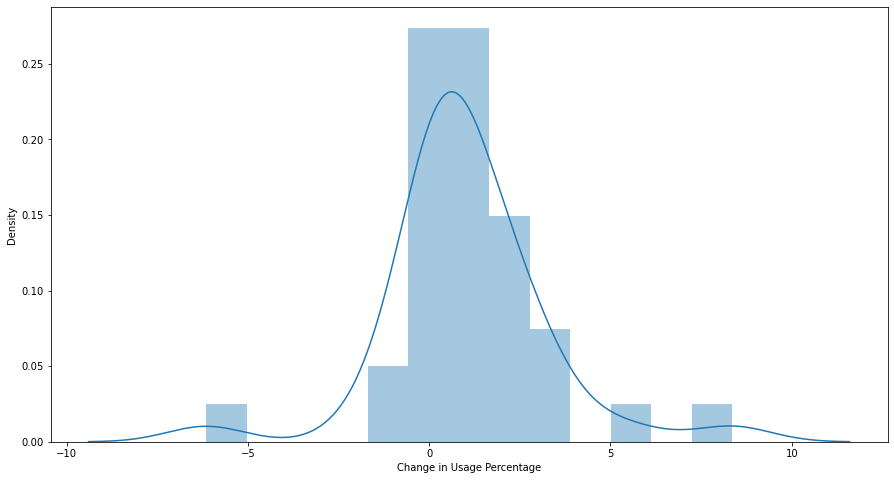

In [27]:
plt.figure(figsize=(15,8))
sns.distplot(x=df_final["change_pct"]).set(xlabel="Change in Usage Percentage")



Looking at the distribution for change in usage percentage of higher performing/newer GPUs, we can see that it is normal with a mean greater than 0 as well as some larger values in both the negative and positive directions. We can determine when these occur.

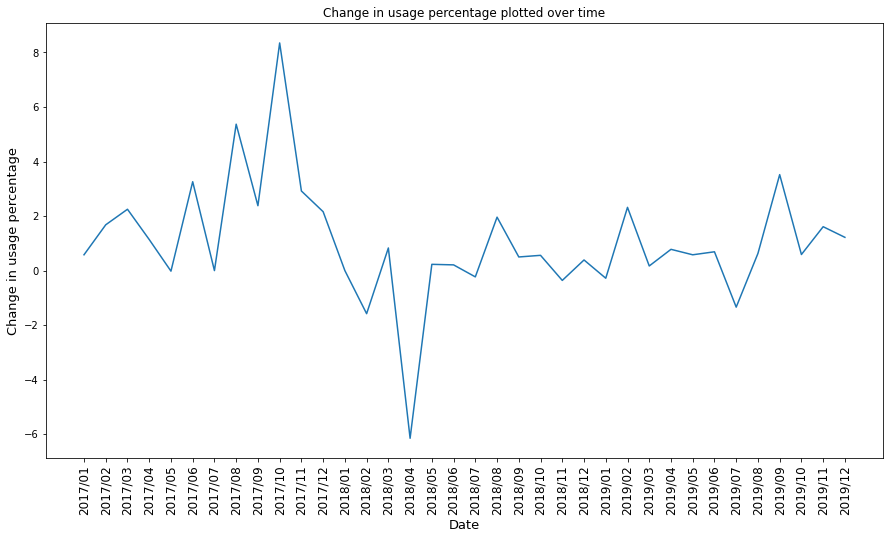

In [69]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="date", y="change_pct", data=df_final)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)
plt.title('Change in usage percentage plotted over time')
plt.xticks(fontsize=12, rotation=90)
plt.show()

We were able to identify where the large values from the distribution plot occurs, but more importantly, we can see that the change in usage percentage has periods of sudden increase and some periods show greater increase than others. Now that we know there exists periods where usage rate of higher performing/newer GPUs, we can begin to analyze if there's any correlation to our popular/demanding variables.

Lets see if any of the popularity variables show any similar patterns

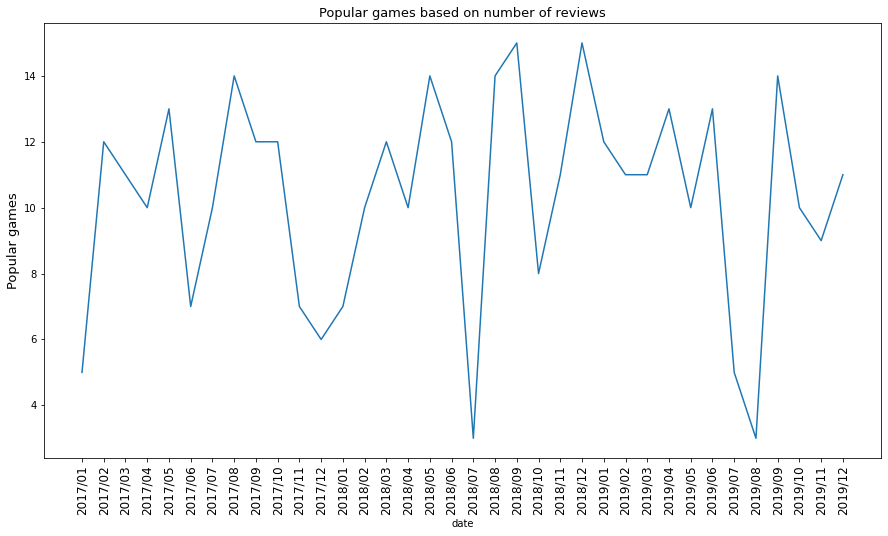

In [51]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="date", y="popular_revs", data=df_final)

plt.xticks(fontsize=12, rotation=90)
plt.title('Popular games based on number of reviews', fontsize = 13)
plt.ylabel('Popular games', fontsize = 13)
plt.show()

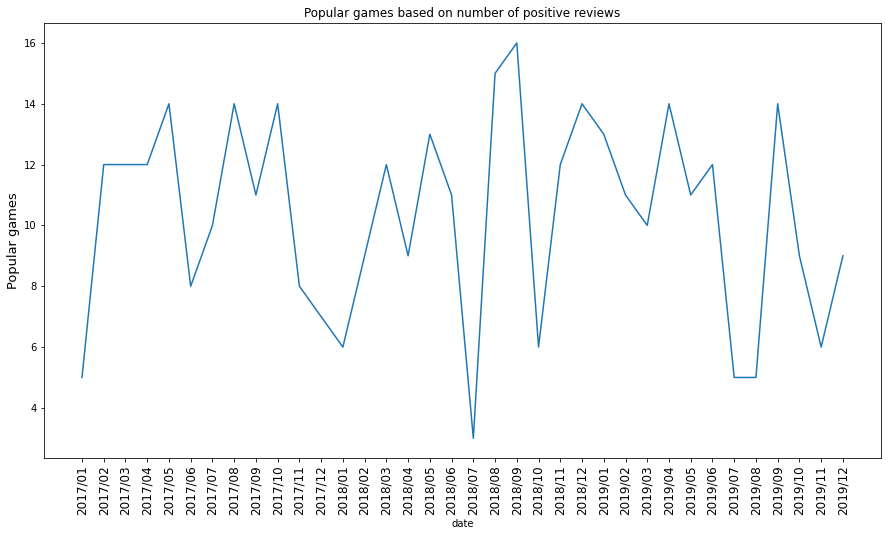

In [49]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="date", y="popular_pos_revs", data=df_final)
plt.ylabel('Popular games', fontsize = 13)
plt.title('Popular games based on number of positive reviews')
plt.xticks(fontsize=12, rotation=90)
plt.show()

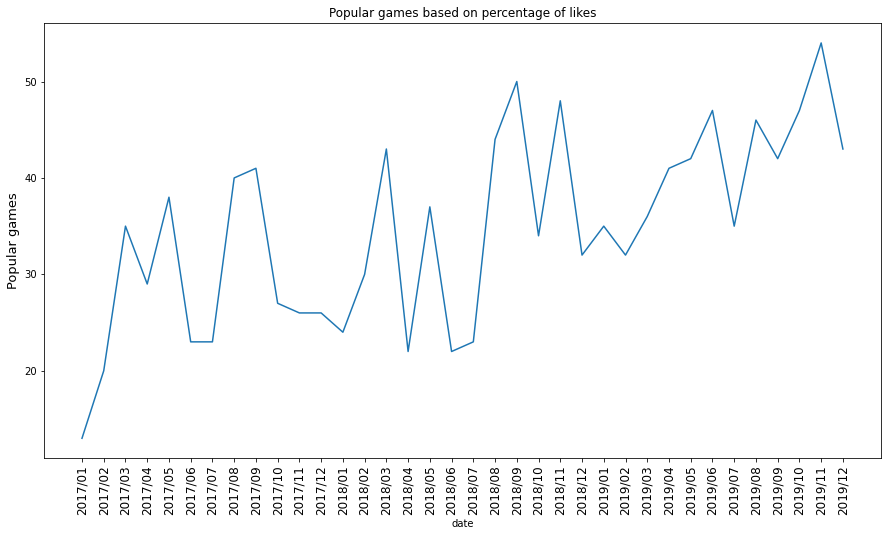

In [52]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="date", y="popular_pct_likes", data=df_final)
plt.title('Popular games based on percentage of likes')
plt.ylabel('Popular games', fontsize = 13)
plt.xticks(fontsize=12, rotation=90)
plt.show()

What do we find about the popularity graphs?

None of them show any significant patterns to the change in usage percentage graph. 

There's a few small differences between the number of games with a popular number of reviews and the number of games with a popular number of positive reviews, but in general, they share a similar pattern. Their slope throughout the years looks to be horizontal, but it isn't entirely clear by simply looking at the graphs.

The graph for number of games with a popular percentage of likes has an upward sloping pattern.

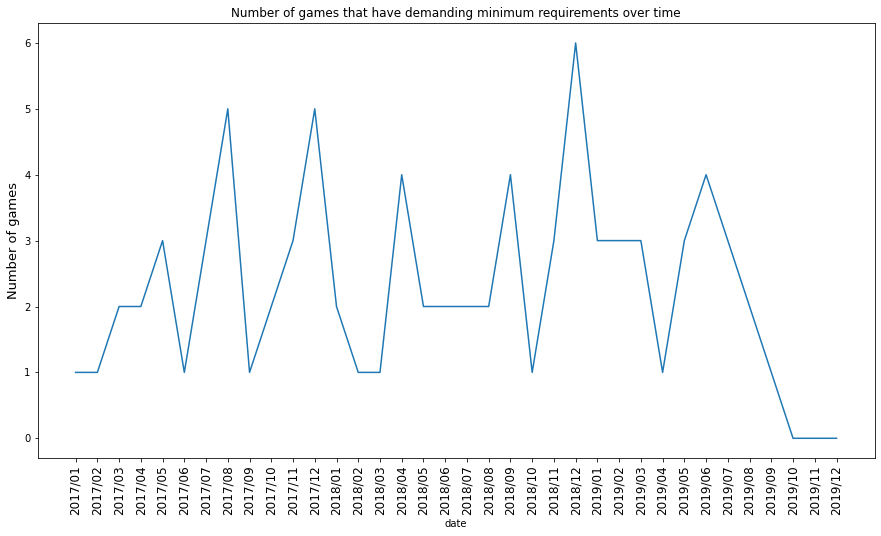

In [54]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="date", y="min_demanding", data=df_final)
plt.title('Number of games that have demanding minimum requirements over time')
plt.ylabel('Number of games', fontsize = 13)

plt.xticks(fontsize=12, rotation=90)
plt.show()

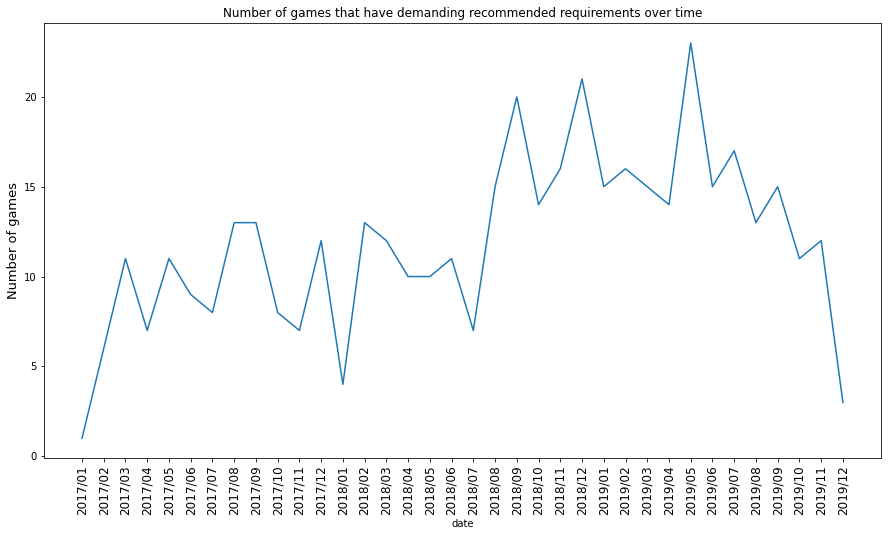

In [55]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="date", y="rec_demanding", data=df_final)
plt.title('Number of games that have demanding recommended requirements over time')
plt.ylabel('Number of games', fontsize = 13)

plt.xticks(fontsize=12, rotation=90)
plt.show()

What do we find about the demanding graphs?

There doesn't appear to be any significant patterns relating to change in usage percentage.

The graph for the number of games with a demanding minimum requirement looks to have a horizontal slope.

The slope of the graph for the number of games with a demanding recommended requirement looks to be positive, but it's not entirely clear since it begins to drop significantly in the later months. 

## Linear Regression

Instead of simply looking for patterns, linear regression models can be used to look for correlations.

Text(0, 0.5, 'Change in usage percentage')

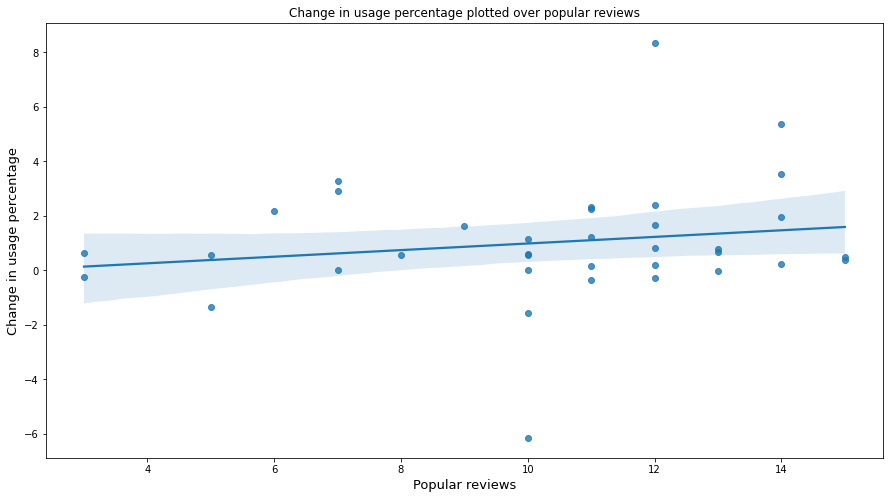

In [72]:
plt.figure(figsize=(15,8))
plt.title('Change in usage percentage plotted over popular reviews')

sns.regplot(x="popular_revs", y="change_pct", data=df_final)
plt.xlabel('Popular reviews', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)

In [105]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.087
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.305
Time:                        17:46:40   Log-Likelihood:                -78.611
No. Observations:                  36   AIC:                             161.2
Df Residuals:                      34   BIC:                             164.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2260      1.256     -0.180      0.858      -2.778       2.326
popular_revs     0.1211      0.116      1.042      0.305      -0.115       0.357
==============================================================================
Omnibus:                       10.716   Durbin-Watson:                   1.519
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               27.624
Skew:                           0.187   Prob(JB):                     1.00e-06
Kurtosis:                       7.275   Cond. No.                         37.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Change in usage percentage')

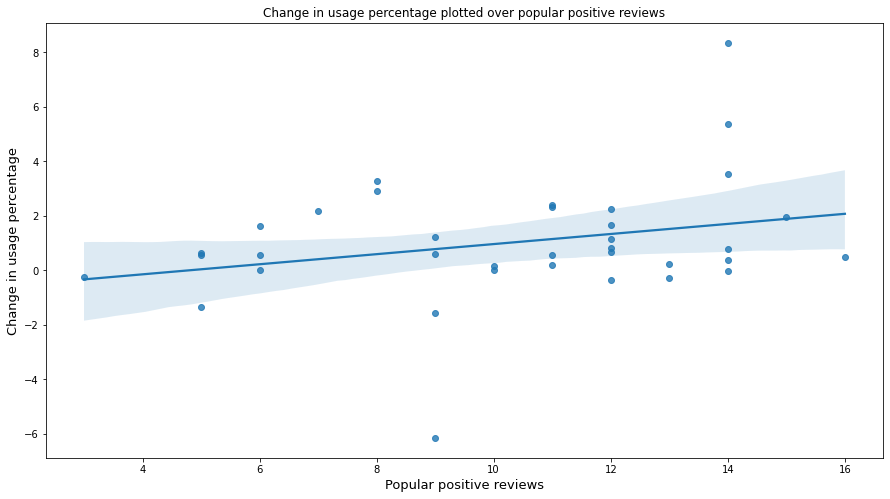

In [71]:
plt.figure(figsize=(15,8))
plt.title('Change in usage percentage plotted over popular positive reviews')

sns.regplot(x="popular_pos_revs", y="change_pct", data=df_final)
plt.xlabel('Popular positive reviews', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)

In [107]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_pos_revs", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.886
Date:                Sun, 21 Nov 2021   Prob (F-statistic):             0.0985
Time:                        17:46:40   Log-Likelihood:                -77.711
No. Observations:                  36   AIC:                             159.4
Df Residuals:                      34   BIC:                             162.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.8859      1.181     -0.750      0.458      -3.287       1.515
popular_pos_revs     0.1850      0.109      1.699      0.099      -0.036       0.406
==============================================================================
Omnibus:                        9.172   Durbin-Watson:                   1.489
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               20.129
Skew:                           0.051   Prob(JB):                     4.26e-05
Kurtosis:                       6.662   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Change in usage percentage plotted over percentage of likes')

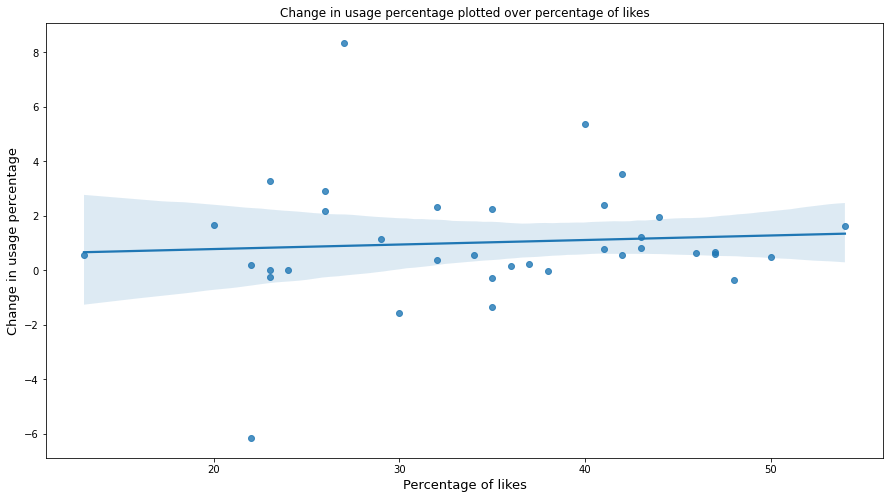

In [70]:
plt.figure(figsize=(15,8))
sns.regplot(x="popular_pct_likes", y="change_pct", data=df_final)
plt.xlabel('Percentage of likes', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)
plt.title('Change in usage percentage plotted over percentage of likes')


In [109]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_pct_likes", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.1913
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.665
Time:                        17:46:40   Log-Likelihood:                -79.077
No. Observations:                  36   AIC:                             162.2
Df Residuals:                      34   BIC:                             165.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.4495      1.369      0.328      0.745      -2.333       3.232
popular_pct_likes     0.0166      0.038      0.437      0.665      -0.060       0.094
==============================================================================
Omnibus:                       11.962   Durbin-Watson:                   1.586
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               29.664
Skew:                           0.421   Prob(JB):                     3.62e-07
Kurtosis:                       7.367   Cond. No.                         132.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Change in usage percentage plotted over # games that have demanding min requirements')

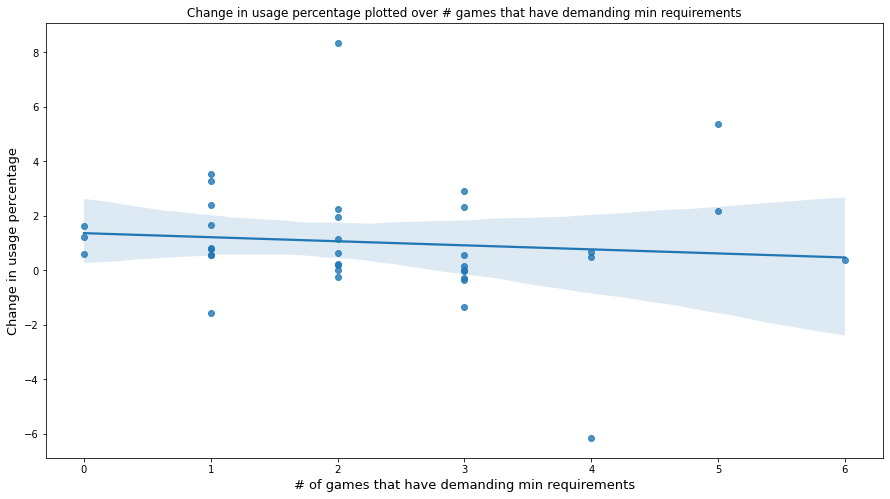

In [67]:
plt.figure(figsize=(15,8))
sns.regplot(x="min_demanding", y="change_pct", data=df_final)
plt.xlabel('# of games that have demanding min requirements', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)
plt.title('Change in usage percentage plotted over # games that have demanding min requirements')

In [111]:
outcome, predictors = patsy.dmatrices("change_pct ~ min_demanding", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.3239
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.573
Time:                        17:46:41   Log-Likelihood:                -79.007
No. Observations:                  36   AIC:                             162.0
Df Residuals:                      34   BIC:                             165.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.3642      0.702      1.943      0.060      -0.062       2.791
min_demanding    -0.1487      0.261     -0.569      0.573      -0.679       0.382
==============================================================================
Omnibus:                       11.693   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               27.858
Skew:                           0.424   Prob(JB):                     8.93e-07
Kurtosis:                       7.225   Cond. No.                         5.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Change in usage percentage plotted over # games that have demanding recommended requirements')

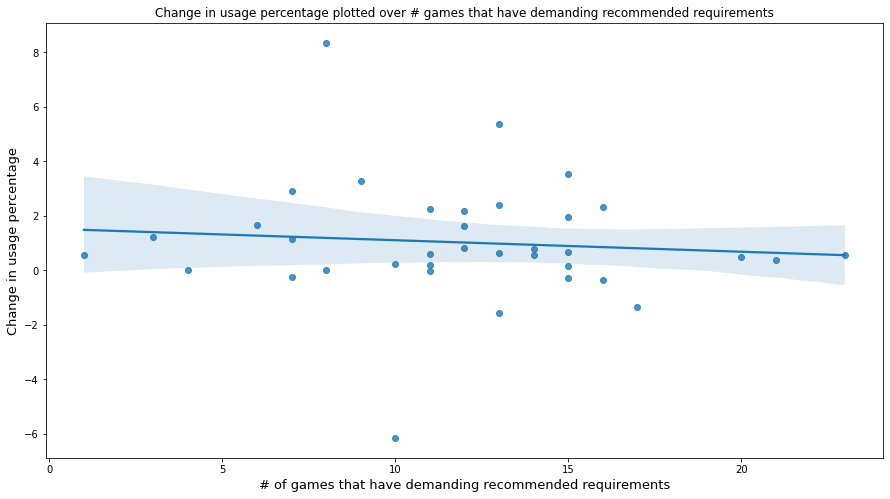

In [68]:
plt.figure(figsize=(15,8))
sns.regplot(x="rec_demanding", y="change_pct", data=df_final)
plt.xlabel('# of games that have demanding recommended requirements', fontsize = 13)
plt.ylabel('Change in usage percentage', fontsize = 13)
plt.title('Change in usage percentage plotted over # games that have demanding recommended requirements')

In [113]:
outcome, predictors = patsy.dmatrices("change_pct ~ rec_demanding", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.2884
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.595
Time:                        17:46:41   Log-Likelihood:                -79.026
No. Observations:                  36   AIC:                             162.1
Df Residuals:                      34   BIC:                             165.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5273      1.006      1.518      0.138      -0.517       3.572
rec_demanding    -0.0422      0.079     -0.537      0.595      -0.202       0.118
==============================================================================
Omnibus:                       10.985   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               29.264
Skew:                           0.193   Prob(JB):                     4.42e-07
Kurtosis:                       7.400   Cond. No.                         34.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Individually, none of them show correlation to change in usage percentage. The 95% confidence interval for all of our popularity variables and demanding variables contained 0. This can be seen in the summaries and in the shaded blue regions of the graphs. 

## Multivariate Linear Regression

Although none of our dependent variables show correlation to the change in number of usage percentage individually, We can try to show correlation through the combination of multiple independent variables.

#### Popular Variables

Independent variables
- popular_revs
- popular_pct_likes

In [114]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + popular_pct_likes", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.5287
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.594
Time:                        17:46:41   Log-Likelihood:                -78.610
No. Observations:                  36   AIC:                             163.2
Df Residuals:                      33   BIC:                             168.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2737      1.576     -0.174      0.863      -3.481       2.933
popular_revs          0.1186      0.127      0.931      0.359      -0.141       0.378
popular_pct_likes     0.0021      0.041      0.051      0.959      -0.081       0.086
==============================================================================
Omnibus:                       10.763   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               27.570
Skew:                           0.208   Prob(JB):                     1.03e-06
Kurtosis:                       7.267   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Independent variables
- popular_pct_likes
- popular_pos_revs

In [115]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_pos_revs + popular_pct_likes", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.407
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.259
Time:                        17:46:41   Log-Likelihood:                -77.705
No. Observations:                  36   AIC:                             161.4
Df Residuals:                      33   BIC:                             166.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7824      1.539     -0.508      0.615      -3.914       2.350
popular_pos_revs      0.1891      0.117      1.616      0.116      -0.049       0.427
popular_pct_likes    -0.0042      0.039     -0.107      0.915      -0.084       0.076
==============================================================================
Omnibus:                        9.185   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               20.283
Skew:                           0.011   Prob(JB):                     3.94e-05
Kurtosis:                       6.677   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Independent variables
- popular_revs
- popular_pos_revs

In [116]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + popular_pos_revs", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     2.590
Date:                Sun, 21 Nov 2021   Prob (F-statistic):             0.0902
Time:                        17:46:41   Log-Likelihood:                -76.553
No. Observations:                  36   AIC:                             159.1
Df Residuals:                      33   BIC:                             163.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3975      1.207     -0.329      0.744      -2.853       2.058
popular_revs        -0.4632      0.313     -1.481      0.148      -1.099       0.173
popular_pos_revs     0.6009      0.301      2.000      0.054      -0.010       1.212
==============================================================================
Omnibus:                        6.798   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.033   Jarque-Bera (JB):               10.438
Skew:                          -0.053   Prob(JB):                      0.00541
Kurtosis:                       5.636   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Independent variables
- All popular variables

In [117]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + popular_pct_likes + popular_pos_revs", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.691
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.188
Time:                        17:46:41   Log-Likelihood:                -76.528
No. Observations:                  36   AIC:                             161.1
Df Residuals:                      32   BIC:                             167.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5853      1.519     -0.385      0.703      -3.679       2.509
popular_revs         -0.4778      0.325     -1.470      0.151      -1.140       0.184
popular_pct_likes     0.0083      0.039      0.209      0.836      -0.072       0.089
popular_pos_revs      0.6060      0.306      1.981      0.056      -0.017       1.229
==============================================================================
Omnibus:                        6.564   Durbin-Watson:                   1.562
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                9.750
Skew:                          -0.000   Prob(JB):                      0.00763
Kurtosis:                       5.550   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Demanding Variables

We find little point in using min_demanding and rec_demanding together as independent variables because if a game has a demanding minimum requirement, then it also has a demanding recommended requirement. However, it is only one linear regression model and including it will not take long.

NOTE: In the multivariate regressions with popular and demanding variables combined, we will separate min_demanding and rec_demanding. In other words, none of the models will contain both min_demanding and rec_demanding.

Independent Variables
- min_demanding
- rec_demanding

In [118]:
outcome, predictors = patsy.dmatrices("change_pct ~ min_demanding + rec_demanding", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.048
Method:                 Least Squares   F-statistic:                    0.2062
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.815
Time:                        17:46:41   Log-Likelihood:                -78.954
No. Observations:                  36   AIC:                             163.9
Df Residuals:                      33   BIC:                             168.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5998      1.039      1.540      0.133      -0.513       3.713
min_demanding    -0.1073      0.296     -0.362      0.719      -0.710       0.495
rec_demanding    -0.0277      0.089     -0.311      0.757      -0.209       0.153
==============================================================================
Omnibus:                       11.200   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.662
Skew:                           0.327   Prob(JB):                     9.85e-07
Kurtosis:                       7.244   Cond. No.                         36.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Summary of Multivariate Regression while Popular and Demanding variables are separated

We still find no correlation while keeping popular and demanding variables separate.

#### min_demanding and Popular variables

##### Independent variables
- popular_revs
- min_demanding

In [119]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + min_demanding", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.8363
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.442
Time:                        17:46:41   Log-Likelihood:                -78.288
No. Observations:                  36   AIC:                             162.6
Df Residuals:                      33   BIC:                             167.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0667      1.319      0.051      0.960      -2.616       2.750
popular_revs      0.1379      0.119      1.160      0.254      -0.104       0.380
min_demanding    -0.2045      0.264     -0.774      0.445      -0.742       0.333
==============================================================================
Omnibus:                       10.881   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               24.228
Skew:                           0.384   Prob(JB):                     5.48e-06
Kurtosis:                       6.945   Cond. No.                         39.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- popular_pct_likes
- min_demanding

In [120]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_pct_likes + min_demanding", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.2324
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.794
Time:                        17:46:41   Log-Likelihood:                -78.926
No. Observations:                  36   AIC:                             163.9
Df Residuals:                      33   BIC:                             168.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.8283      1.559      0.531      0.599      -2.344       4.001
popular_pct_likes     0.0149      0.038      0.386      0.702      -0.063       0.093
min_demanding        -0.1399      0.266     -0.527      0.602      -0.680       0.400
==============================================================================
Omnibus:                       12.409   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.143
Skew:                           0.540   Prob(JB):                     7.74e-07
Kurtosis:                       7.195   Cond. No.                         150.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- popular_pos_revs
- min_demanding

In [121]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_pos_revs + min_demanding", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     2.031
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.147
Time:                        17:46:41   Log-Likelihood:                -77.088
No. Observations:                  36   AIC:                             160.2
Df Residuals:                      33   BIC:                             164.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5767      1.213     -0.475      0.638      -3.044       1.891
popular_pos_revs     0.2170      0.113      1.927      0.063      -0.012       0.446
min_demanding       -0.2810      0.261     -1.079      0.289      -0.811       0.249
==============================================================================
Omnibus:                        8.745   Durbin-Watson:                   1.463
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               15.421
Skew:                           0.313   Prob(JB):                     0.000448
Kurtosis:                       6.145   Cond. No.                         37.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- popular_revs
- popular_pct_likes
- min_demanding

In [122]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + min_demanding + popular_pct_likes", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.5428
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.656
Time:                        17:46:41   Log-Likelihood:                -78.284
No. Observations:                  36   AIC:                             164.6
Df Residuals:                      32   BIC:                             170.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1472      1.679      0.088      0.931      -3.273       3.568
popular_revs          0.1421      0.132      1.078      0.289      -0.126       0.411
min_demanding        -0.2082      0.272     -0.764      0.450      -0.763       0.347
popular_pct_likes    -0.0033      0.042     -0.079      0.937      -0.089       0.082
==============================================================================
Omnibus:                       10.730   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               24.129
Skew:                           0.356   Prob(JB):                     5.76e-06
Kurtosis:                       6.947   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- popular_pos_revs
- popular_pct_likes
- min_demanding

In [123]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_pos_revs + min_demanding + popular_pct_likes", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.350
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.276
Time:                        17:46:41   Log-Likelihood:                -77.032
No. Observations:                  36   AIC:                             162.1
Df Residuals:                      32   BIC:                             168.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2513      1.608     -0.156      0.877      -3.527       3.024
popular_pos_revs      0.2311      0.123      1.884      0.069      -0.019       0.481
min_demanding        -0.2970      0.269     -1.104      0.278      -0.845       0.251
popular_pct_likes    -0.0125      0.040     -0.314      0.756      -0.094       0.069
==============================================================================
Omnibus:                        8.334   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               15.087
Skew:                           0.211   Prob(JB):                     0.000530
Kurtosis:                       6.143   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- popular_revs
- popular_pos_revs
- min_demanding

In [124]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + min_demanding + popular_pos_revs", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     2.449
Date:                Sun, 21 Nov 2021   Prob (F-statistic):             0.0816
Time:                        17:46:41   Log-Likelihood:                -75.457
No. Observations:                  36   AIC:                             158.9
Df Residuals:                      32   BIC:                             165.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0913      1.238      0.074      0.942      -2.430       2.613
popular_revs        -0.5462      0.314     -1.742      0.091      -1.185       0.093
min_demanding       -0.3647      0.257     -1.417      0.166      -0.889       0.160
popular_pos_revs     0.7170      0.307      2.334      0.026       0.091       1.343
==============================================================================
Omnibus:                        5.633   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                6.340
Skew:                           0.248   Prob(JB):                       0.0420
Kurtosis:                       4.995   Cond. No.                         55.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- All popular variables
- min_demanding

In [125]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + min_demanding + popular_pos_revs + popular_pct_likes", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1.779
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.158
Time:                        17:46:41   Log-Likelihood:                -75.457
No. Observations:                  36   AIC:                             160.9
Df Residuals:                      31   BIC:                             168.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0953      1.577      0.060      0.952      -3.122       3.312
popular_revs         -0.5459      0.324     -1.684      0.102      -1.207       0.115
min_demanding        -0.3649      0.265     -1.378      0.178      -0.905       0.175
popular_pos_revs      0.7169      0.312      2.296      0.029       0.080       1.354
popular_pct_likes    -0.0002      0.039     -0.004      0.997      -0.081       0.080
==============================================================================
Omnibus:                        5.633   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                6.344
Skew:                           0.248   Prob(JB):                       0.0419
Kurtosis:                       4.996   Cond. No.                         174.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### rec_demanding and Popular variables

##### Independent variables
- popular_revs
- rec_demanding

In [126]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + rec_demanding", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.065
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.356
Time:                        17:46:41   Log-Likelihood:                -78.052
No. Observations:                  36   AIC:                             162.1
Df Residuals:                      33   BIC:                             166.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2864      1.352      0.212      0.834      -2.464       3.036
popular_revs      0.1703      0.126      1.354      0.185      -0.085       0.426
rec_demanding    -0.0858      0.084     -1.021      0.315      -0.257       0.085
==============================================================================
Omnibus:                       10.364   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               26.861
Skew:                          -0.040   Prob(JB):                     1.47e-06
Kurtosis:                       7.231   Cond. No.                         60.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- popular_pct_likes
- rec_demanding

In [127]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_pct_likes + rec_demanding", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.5393
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.588
Time:                        17:46:41   Log-Likelihood:                -78.599
No. Observations:                  36   AIC:                             163.2
Df Residuals:                      33   BIC:                             167.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6742      1.392      0.484      0.631      -2.157       3.506
popular_pct_likes     0.0408      0.046      0.890      0.380      -0.053       0.134
rec_demanding        -0.0897      0.095     -0.942      0.353      -0.283       0.104
==============================================================================
Omnibus:                       11.688   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               27.115
Skew:                           0.445   Prob(JB):                     1.29e-06
Kurtosis:                       7.157   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- popular_pos_revs
- rec_demanding

In [128]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_pos_revs + rec_demanding", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.399
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.106
Time:                        17:46:41   Log-Likelihood:                -76.734
No. Observations:                  36   AIC:                             159.5
Df Residuals:                      33   BIC:                             164.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2220      1.265     -0.175      0.862      -2.796       2.352
popular_pos_revs     0.2480      0.117      2.117      0.042       0.010       0.486
rec_demanding       -0.1106      0.082     -1.357      0.184      -0.277       0.055
==============================================================================
Omnibus:                        9.444   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               19.426
Skew:                          -0.257   Prob(JB):                     6.05e-05
Kurtosis:                       6.562   Cond. No.                         59.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- popular_revs
- popular_pct_likes
- rec_demanding

In [129]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + rec_demanding + popular_pct_likes", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.8258
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.489
Time:                        17:46:42   Log-Likelihood:                -77.835
No. Observations:                  36   AIC:                             163.7
Df Residuals:                      32   BIC:                             170.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1943      1.568     -0.124      0.902      -3.389       3.000
popular_revs          0.1529      0.130      1.177      0.248      -0.112       0.418
rec_demanding        -0.1152      0.097     -1.186      0.244      -0.313       0.083
popular_pct_likes     0.0291      0.047      0.622      0.538      -0.066       0.124
==============================================================================
Omnibus:                       10.152   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.449
Skew:                           0.172   Prob(JB):                     4.91e-06
Kurtosis:                       7.023   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables:
- popular_pos_revs
- popular_pct_likes
- rec_demanding

In [130]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_pos_revs + rec_demanding + popular_pct_likes", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1.709
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.185
Time:                        17:46:42   Log-Likelihood:                -76.503
No. Observations:                  36   AIC:                             161.0
Df Residuals:                      32   BIC:                             167.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7435      1.512     -0.492      0.626      -3.824       2.337
popular_pos_revs      0.2373      0.119      1.988      0.055      -0.006       0.481
rec_demanding        -0.1409      0.095     -1.487      0.147      -0.334       0.052
popular_pct_likes     0.0286      0.044      0.644      0.524      -0.062       0.119
==============================================================================
Omnibus:                        8.415   Durbin-Watson:                   1.609
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               16.518
Skew:                          -0.066   Prob(JB):                     0.000259
Kurtosis:                       6.316   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- popular_revs
- popular_pos_revs
- rec_demanding

In [131]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + rec_demanding + popular_pos_revs", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2.349
Date:                Sun, 21 Nov 2021   Prob (F-statistic):             0.0910
Time:                        17:46:42   Log-Likelihood:                -75.595
No. Observations:                  36   AIC:                             159.2
Df Residuals:                      32   BIC:                             165.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2232      1.282      0.174      0.863      -2.389       2.835
popular_revs        -0.4475      0.309     -1.446      0.158      -1.078       0.183
rec_demanding       -0.1062      0.080     -1.322      0.195      -0.270       0.057
popular_pos_revs     0.6473      0.299      2.163      0.038       0.038       1.257
==============================================================================
Omnibus:                        7.712   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               11.779
Skew:                          -0.298   Prob(JB):                      0.00277
Kurtosis:                       5.738   Cond. No.                         72.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Independent variables
- All popular variables
- rec_demanding

In [132]:
outcome, predictors = patsy.dmatrices("change_pct ~ popular_revs + rec_demanding + popular_pos_revs + popular_pct_likes", df_final)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             change_pct   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2.020
Date:                Sun, 21 Nov 2021   Prob (F-statistic):              0.116
Time:                        17:46:42   Log-Likelihood:                -75.009
No. Observations:                  36   AIC:                             160.0
Df Residuals:                      31   BIC:                             167.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5257      1.480     -0.355      0.725      -3.544       2.493
popular_revs         -0.5200      0.318     -1.638      0.112      -1.168       0.128
rec_demanding        -0.1531      0.093     -1.652      0.109      -0.342       0.036
popular_pos_revs      0.6952      0.303      2.296      0.029       0.078       1.313
popular_pct_likes     0.0450      0.044      1.013      0.319      -0.046       0.136
==============================================================================
Omnibus:                        5.575   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                6.861
Skew:                          -0.094   Prob(JB):                       0.0324
Kurtosis:                       5.130   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Summary of Multivariate Regressions while Popular and Demanding variables were combined

Above we have 14 different combinations of popular and demanding variables. These are the correlations we were able to find:

#### min_demanding and Popular variables Summary

##### Independent variables
- popular_revs
- popular_pos_revs
- min_demanding

When using popular_revs and popular_pos_revs only, we get a correlation for popular_pos_revs with a slope of 0.7170.

##### Independent variables
- All popular variables
- min_demanding

When using all popular variables, we get a correlation for popular_pos_revs with a slope of 0.7169.

While using these two combinations of variables, we were able to find a correlation between change in usage percentage and number of games with popular number of positive reviews and an R-squared value of 0.187 for both combinations. 

#### rec_demanding and Popular variables Summary

##### Independent variables
- popular_pos_revs
- rec_demanding

When using popular_pos_revs only, we get a correlation for popular_pos_revs with a slope of 0.248, R-squared value of 0.127

##### Independent variables
- popular_revs
- popular_pos_revs
- rec_demanding

When using popular_revs and popular_pos_revs only, we get a correlation for popular_pos_revs with a slope of 0.6472, R-squared value of 0.18

##### Independent variables
- All popular variables
- rec_demanding

When using all popular variables, we get a correlation for popular pos_revs with a slope of 0.6952, R-squared value of 0.207

While using these three combinations of variables, we were able to find a correlation between change in usage percentage and number of games with popular number of positive reviews.

#### Summary of Multivariate Regression

We weren't able to find any correlations when keeping popular and demanding variables separate, however, when combining these two, we were able to find a correlation. Specifically with the number of games with popular number of positive reviews. 

In multiple regression models with combined popular and demanding variables, we were able to find a slight positive correlation between change in usage percentage and number of games with popular number of positive reviews. 

## Issues

##### Change in usage percentage as an indication of sales numbers
- We were unable to attain GPU sales numbers and as a substitute, we used the change in usage percentage. A problem with this is we're only able to make correlation claims about popular, demanding games and change in usage percentage and from this, and therefore, we can only use the results of this analysis as one possible indication to GPU sales. 

##### Steam Survey
- Although the Steam Survey provided us with much useful information, it is voluntary. Also, information like how many people participated in the survey and who participated in the survey is unknown to us.

In [12]:
# # Run this to get df_final
df_final = pd.read_csv("df_final.csv")